The presented notebook is a tool designed for analyzing and classifying B-cell lymphomas, specifically those belonging to the DLBCL subtype. It begins by loading a reference cohort along with its annotation file, an example gene expression matrix, and a gene signature file located in the Datasets folder. A PCA analysis plot of the reference cohort is shown to confirm that there are no batch effects present in the data.

Next, the example gene expression matrix is prepared along with its annotation file. A quality check is performed to ensure that the data is suitable for analysis and free from any issues that may impact the accuracy of the calculations.

Once the KNN model has been created based on the reference cohort and the example gene expression matrix has been checked for quality, the ssGSEA scores are calculated using the ssgsea_formula function. Based on the ssGSEA scores of the gene signatures in the example data and the KNN model of the reference cohort, the classification is performed, and the results are displayed in a pie-plot that shows the percentages of each LME subtype in the entire cohort.

Additionally, a heatmap is provided to show the expression levels of the signatures in the example cohort data, which is divided into four LME subtypes, each of which is further divided into two DLBCL subtypes: ABC-DLBCL and GCB-DLBCL.

# Import of Python base packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False
import matplotlib.pyplot as plt
import copy
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from pathlib import Path

In [2]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('white')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from lme.utils import *
from lme.plotting import *
from lme.classification import *
from lme.pathway_scoring import *

In [5]:
# Loading constants
REFERENCE_COHORT_ANNOTATION = 'datasets/pan_cohort_annotation.tsv'
REFERENCE_COHORT_EXPRESSION = 'datasets/pan_cohort_signatures.tsv.gz'
EXPRESSION_MATRIX = 'datasets/GSE56313/expressions.tsv.gz'
EXPRESSION_MATRIX_ANNOTATION = 'datasets/GSE56313/annotation.tsv'
GENE_SIGNATURES = 'databases/signatures.gmt'

# Data preparation 

## Loading gene signatures

In [6]:
# Loading reading gene signatures from the gene_signatures.gmt file
signatures = read_gene_sets(GENE_SIGNATURES)
signatures

{'Lymphatic_endothelium': Lymphatic_endothelium (Lymphatic endothelium): PDPN,FOXC2,SOX18,CXADR,CCL21,CXCL12,PPP1R13B,LYVE1,FLT4,JAM2,EDNRB,PROX1,JAM3,
 'Angiogenesis': Angiogenesis (Angiogenesis): VEGFC,VWF,VEGFA,ANGPT1,FLT1,PGF,CXCR2,CXCL8,KDR,PDGFC,ANGPT2,CDH5,TEK,CXCL5,VEGFB,
 'CAF': CAF (Cancer Associated Fibroblasts): COL4A1,COL11A1,CTGF,S100A4,TGFB3,CD248,PTGS2,LUM,FN1,COL6A1,MMP7,ACTA2,COL5A1,TIMP1,MMP2,LGALS1,MMP1,LRP1,TGFB1,MMP9,PRELP,COL6A2,FGF2,MMP12,COL1A2,MFAP5,LGALS9,TGFB2,COL6A3,CA9,FAP,COL1A1,FBLN1,MMP3,
 'Fibroblastic_reticular_cells': Fibroblastic_reticular_cells (Fibroblastic reticular cells): ACTA2,PDPN,VIM,LTBR,PDGFRA,DES,VCAM1,PTGS2,NT5E,THY1,ICAM1,
 'Matrix': Matrix (Matrix): COL4A1,LGALS7,COL1A1,FN1,VTN,COL1A2,COL3A1,
 'Matrix_remodeling': Matrix_remodeling (Matrix remodeling): TIMP1,MMP9,MMP2,TIMP2,CA9,
 'Granulocyte_traffic': Granulocyte_traffic (Granulocyte traffic): CCR3,KITLG,CXCL2,CCL11,CXCR1,CXCR2,CXCL8,CXCL5,KIT,CXCL1,
 'Protumor_cytokines': Protumor_cy

In [7]:
# Creating a list of selected/needed signatures for further calssification
signatures_selected = [
 'Lymphatic_endothelium',
 'Angiogenesis',
 'CAF',
 'Fibroblastic_reticular_cells',
 'Matrix',
 'Matrix_remodeling',
 'Granulocyte_traffic',
 'Protumor_cytokines',
 'Follicular_dendritic_cells',
 'Macrophages',
 'M1_signature',
 'T_cell_traffic',
 'MHCII',
 'MHCI',
 'Follicular_B_helper_T_cells',
 'Treg',
 'T_cells',
 'Checkpoint_inhibition',
 'NK_cells',
 'B_cells_traffic',
 'B_cells',
 'Proliferation_rate']
len(signatures_selected)

22

In [8]:
# reating a list of the signaling pathwa signatures
progeny_selected = ['NFkB', 'p53', 'PI3K']
len(progeny_selected)

3

<AxesSubplot:>

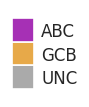

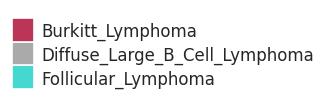

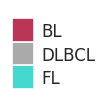

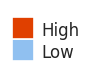

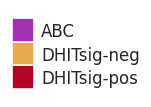

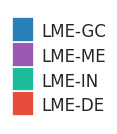

In [9]:
# Generating color palette for DLBCL GCB and ABC subtypes

dlbcl_subtype_p = {'ABC': '#A630B5', 'GCB': '#E7A949', 'UNC': '#AAAAAA'}
patch_plot(dlbcl_subtype_p)

# Generating color pallete of colors for different lymphoma types: Burrkits Lymphoma, Follicular Lymphoma, Diffuse large B-cell lymphoma

diagnosis_p = {'Burkitt_Lymphoma': '#BB3556',
         'Diffuse_Large_B_Cell_Lymphoma': '#AAAAAA',
         'Follicular_Lymphoma': '#44D8D1'}
patch_plot(diagnosis_p)

# Shortening names for each lymphoma type mentioned above

diagnosis_shortener = {'Diffuse_Large_B_Cell_Lymphoma': 'DLBCL', 'Follicular_Lymphoma': 'FL',
               'Burkitt_Lymphoma': 'BL'}
diagnosis_rn_p = {'BL': '#BB3556',
         'DLBCL': '#AAAAAA',
         'FL': '#44D8D1'}
patch_plot(diagnosis_rn_p)

# Generating color pallete for high and low values

high_low_p = {'High': '#E04000', 
              'Low': '#90C0F0'}
high_low_o = ['High', 'Low']
high_low_map = {True:'High',
                False: 'Low'}
patch_plot(high_low_p)

# Generating color pallete for DHIT sig positive and negative conditions

dhit_p = {'DHITsig-neg': dlbcl_subtype_p['GCB'], 'DHITsig-pos': '#b40426', 'ABC': dlbcl_subtype_p['ABC']}

patch_plot(dhit_p)

# Generating color palette for LME subtypes 

lme_o = ['LME-GC', 'LME-ME', 'LME-IN', 'LME-DE', ]
lme_p = {
            'LME-GC': '#2980B9',
            'LME-ME': '#9B59B6', 
            'LME-IN': '#1ABC9C', 
            'LME-DE': '#E74C3C',}

patch_plot(lme_p, order=lme_o)

## Reading the reference cohort annotation file

In [10]:
# Reading reference cohort annotation file
cohort_ann = read_dataset(REFERENCE_COHORT_ANNOTATION)
cohort_ann.shape

(5116, 32)

In [11]:
cohort_ann.head()

,Cohort,Cohort_group,SORTN,COO_BG,COO_original,LME,DHITsig_predicted,DHITsig_original,Diagnosis,GenClass7,...,DLBCL90-Group,COO_RT,COO_Hans,Transformed_FL,series_ids,geo_accessions,dbGAP_id,ID1,ID2,platform_id
Sample,,,,,,,,,,,,,,,,,,,,,
GSM3302930,GSE117556,GSE117556,1,ABC,ABC,LME-ME,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302930,NaN,RMDB_1,NaN,GPL14951
GSM3302931,GSE117556,GSE117556,2,GCB,GCB,LME-GC,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302931,NaN,RMDB_2,NaN,GPL14951
GSM3302932,GSE117556,GSE117556,3,GCB,GCB,LME-GC,DHITsig-pos,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302932,NaN,RMDB_3,NaN,GPL14951
GSM3302933,GSE117556,GSE117556,4,ABC,ABC,LME-DE,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302933,NaN,RMDB_4,NaN,GPL14951
GSM3302934,GSE117556,GSE117556,5,GCB,GCB,LME-ME,DHITsig-pos,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302934,NaN,RMDB_5,NaN,GPL14951


## Loading the reference cohort

In [12]:
# Reading reference cohort gene expressions
cohort_sign_sc = read_dataset(REFERENCE_COHORT_EXPRESSION).T
cohort_sign_sc.shape

(5116, 38)

In [13]:
cohort_sign_sc.head()

,EGFR,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,...,B_cells_traffic,Follicular_B_helper_T_cells,Th1_signature,T_cells,Checkpoint_inhibition,MHCII,MHCI,NK_cells,B_cells,Proliferation_rate
DLC0001,-1.100459,1.778296,-0.010550,0.370199,1.009720,-0.995537,0.312762,1.193305,0.933070,-1.007430,...,1.901869,4.907127,2.858243,1.984391,1.646320,0.214866,-0.519421,0.392673,0.138287,-2.709766
DLC0002,1.515182,2.768054,0.654394,2.370840,0.975191,-0.899303,1.767230,1.801683,1.415524,-1.277588,...,0.273988,-0.073384,-0.736010,0.176268,0.479735,-0.543240,-1.204911,0.021682,0.883285,0.618806
DLC0003,-0.855085,0.215444,2.023212,0.471082,1.987488,0.090416,-0.489591,0.438043,1.810002,-1.136433,...,-0.014866,1.135015,1.718405,2.099066,1.630966,0.098000,-1.170603,2.067505,-2.015865,-0.399773
DLC0004,1.170281,2.552209,1.924494,2.637014,1.168497,-2.202614,3.159769,1.717606,2.066829,-1.815582,...,-1.195651,0.289175,-0.450115,1.134542,-0.586538,0.067294,-0.608622,2.168512,-0.309114,-2.152889
DLC0005,-0.414280,0.536973,2.633446,0.993703,0.666727,-1.963422,1.470179,0.737218,2.252673,-1.626322,...,0.895766,3.279645,1.519968,1.882563,1.718104,0.507834,-0.551072,0.550601,0.164978,-1.908548


In [14]:
len(cohort_sign_sc.index & cohort_ann.index)

5116

# Confirming that reference cohort does not have any batch effects

This section provide results from 2 different pca analyse where one is done based on Reference Cohort groups of each sample and the other one is done based on LME subtypes of each sample.
On the figure below you can see that there are not any batches in the pca_plot which indicates that the data has no probles.

![PCA of Reference](reference_cohort_pca_by_cohort_group.svg)

Here on the second figure below is presented the pca_plot that is done based on LME subtypes of each sample. Here also you can see that there are no any batch effects in the dataset. Combining this two results we can be significant that the reference cohort data doesn't have any problems and can be used in the further analysis. 

![Referene pca grouped by LME](reference_cohort_pca_by_lme.svg)

## Creating a KNN model based on reference cohort

In [15]:
cohort_ann_filtered = cohort_ann[(cohort_ann.Diagnosis=='Diffuse_Large_B_Cell_Lymphoma') & 
                                 (~cohort_ann.LME.isna())]
cohort_ann_filtered.shape

(4656, 32)

In [16]:
LME_MODEL = KNeighborsClusterClassifier(norm=False, scale=False, clip=3, k=35).fit(
    *to_common_samples([cohort_sign_sc[signatures_selected + progeny_selected], cohort_ann_filtered.LME]))

In [17]:
LME_MODEL

# Preparation and QC of gene expression matrix

## Read example data gene expression

In [18]:
ann = read_dataset(EXPRESSION_MATRIX_ANNOTATION)
ann.shape

(55, 12)

In [19]:
ann.head()

,Patient,Cohort,Cohort_group,Diagnosis,BAGS_class,CD79B_Status,EZH2_Status,MYD88_Status,COO,COO_BG,DHITsig,platform_id
Sample,,,,,,,,,,,,
GSM1358939,H1,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centrocyte,WT,WT,WT,ABC,GCB,DHITsig-neg,GPL570
GSM1358940,H10,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Unclassified,NaN,WT,NaN,ABC,ABC,DHITsig-neg,GPL570
GSM1358941,H11,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centroblast,NaN,WT,WT,GCB,GCB,DHITsig-neg,GPL570
GSM1358942,H12,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centrocyte,WT,WT,WT,GCB,GCB,DHITsig-neg,GPL570
GSM1358943,H13,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centroblast,WT,WT,WT,ABC,ABC,DHITsig-neg,GPL570


Genes should be in columns, samples in rows  
Make sure it is log2 transformed one time (mean expressions should be between 0 and 18)

In [20]:
exp = np.log2(1+read_dataset(EXPRESSION_MATRIX).T)

In [21]:
exp.head()

Gene_symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZYX,ZZEF1,ZZZ3,abParts,av27s1,hADV36S1,hsa-let-7a-3,hsa-let-7b,hsa-mir-4763,mir-223
GSM1358939,3.398629,3.229542,2.242460,8.975672,2.932449,2.340419,2.625855,4.157479,2.242557,2.410004,...,7.919923,7.535532,9.066579,4.544640,2.242722,2.411134,2.24246,2.24246,2.24246,4.002745
GSM1358940,2.242460,3.358790,2.242460,10.830553,3.451486,2.251113,2.242460,3.012059,2.242557,2.242460,...,8.337970,7.966719,9.343023,5.076570,2.242722,2.245702,2.24246,2.24246,2.24246,4.787586
GSM1358941,2.390763,3.895996,2.762986,9.225935,2.453358,2.242460,2.242460,3.308393,2.242557,2.517436,...,10.429838,8.965752,8.243231,4.823728,2.259413,2.587467,2.24246,2.24246,2.24246,4.002745
GSM1358942,2.390763,2.753845,2.242460,10.882917,2.980621,2.251113,2.242460,3.130747,2.242557,2.242460,...,8.937943,8.583962,8.718742,8.438893,2.242722,2.245702,2.24246,2.24246,2.24246,7.509161
GSM1358943,2.405299,3.218549,2.246557,9.335253,2.434799,2.435370,2.242460,3.539215,2.242557,2.242460,...,9.278991,7.003909,8.552902,5.163131,2.540013,3.346210,2.24246,2.24246,2.24246,5.609699


## Quality check for the example data

The Quality Control (QC) section is tasked with identifying batches, outliers, and assessing the normality of data distribution using various techniques such as PCA plot, UMAP plot, and distribution plot.

As part of your role in this section, you will be provided with examples of both poor and good datasets, which will help you identify the visual differences between them and understand the types of issues that can arise in data. This knowledge will enable you to effectively assess the quality of the data and identify any potential issues that may impact downstream analyses.

## Batch effect detection

This section is responsible for identifying any potential batch effects in the data using UMAP and PCA analyses. The results of these analyses are then plotted to visualize any potential batches in the data.

If you are not familiar with batch effects please follow the link below for more information: https://towardsdatascience.com/batch-effects-c71c886ca9c5

To illustrate this process, an example is provided below with two side-by-side plots. The plot on the left is a good example with no identified issues, whereas the plot on the right exhibits potential batch effects.

One key difference between the two figures is the presence of two distinct groups of data points that are separated from each other in the batch-affected example. This is indicative of a potential batch effect, which can have significant impacts on downstream analyses.

If the plot of your data resembles the one on the right, it is crucial to take action to remove any identified batch effects to ensure accurate and reliable analysis.

For the instructions of batch effects removal use the link provided below: https://github.com/chichaumiau/removeBatcheffect

![Umap plot example](oop/umap_example.svg)

<AxesSubplot:>

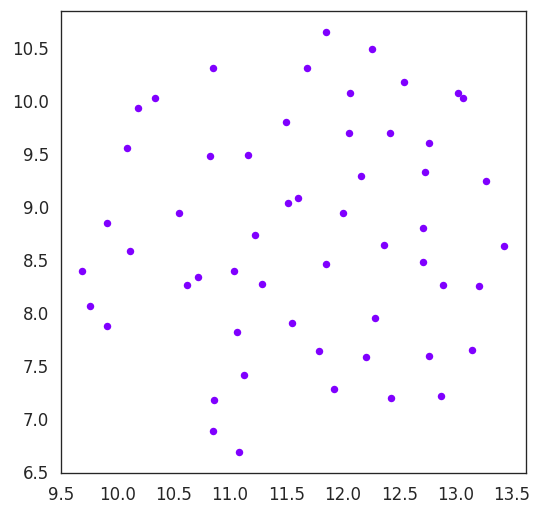

In [22]:
# generating umap_plot for our input data
umap_plot(exp, legend = 'Out')

To further enhance the significance of our analysis, we perform PCA analyses and plot the results to ensure that our data is free from any batch effects.

An illustrative example is provided below, where it is clear that the presence of batches is reflected in the plot as two distinct groups of data points that are far from each other. In contrast, a normal dataset appears as a single group of data points that are relatively close to each other, as reflected in the PCA plot.

This step is essential to ensure that our data is free from any systematic variation that could confound our analyses, and to ensure that any observed effects are biologically meaningful.

![PCA plot of examples](oop/pca_example.svg)

<AxesSubplot:xlabel='PCA 1 component 10% variance explained', ylabel='PCA 2 component 7% variance explained'>

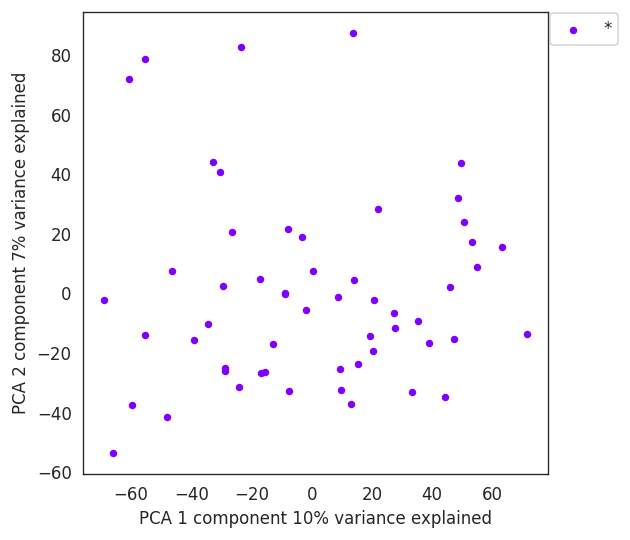

In [23]:
#generating the pca plot for the annotated_expressions
pca_plot(exp, legend = 'out')

## Outlier detection

The purpose of this section is to identify outliers in the annotated_expression data through PCA analysis and the generation of corresponding plots.

The code cell below generates a PCA plot of the transposed annotated_expression data. Transposing the data allows for the sample IDs to be located in the row positions, which facilitates dimension reduction based on samples. This plot can help identify any outliers that may exist in the data.

An example of two datasets is provided below, with one dataset containing outliers and the other dataset being normal.

In the plot on the left, two data points are far away from the main group of data points, indicating the presence of outliers in the dataset. In contrast, the data points in the plot on the right are relatively close to each other, with no outliers detected. It is important to carefully examine plots like these to detect any outliers that may exist in the data.

To get more familiar with outliers and their removal use the link below: https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

![Pca plot with data that has/does not have outliers](pca_outliers_example.svg)

<AxesSubplot:xlabel='PCA 1 component 10% variance explained', ylabel='PCA 2 component 7% variance explained'>

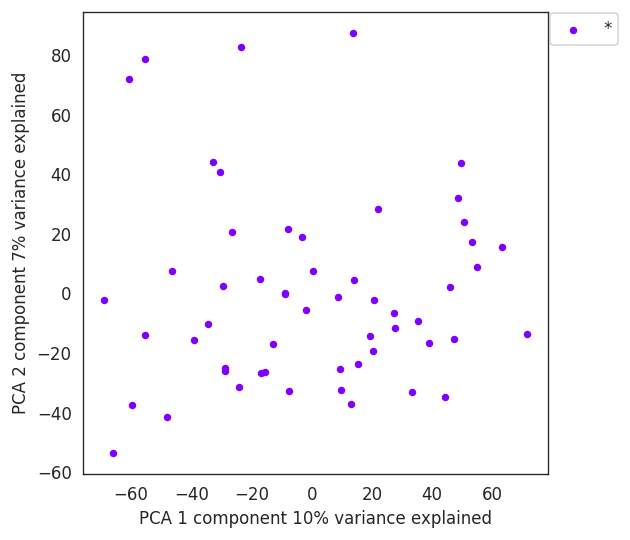

In [24]:
pca_plot(exp, legend='out')

## Data distribution check

As with the previous sections, an example of two gene expression datasets is provided below, with one exhibiting good quality and the other exhibiting poor quality, as indicated by their respective distribution plots.

In the plot on the right, the expression values start off very low and then rise before dropping down. This pattern suggests potential gene degradation, which can compromise the reliability and accuracy of downstream analyses. In contrast, the distribution plot on the left appears to be normal, indicating good quality gene expression data.

It is essential to carefully examine the distribution plots of gene expression data to ensure that the data meets the necessary quality criteria for accurate and reliable analyses. Any deviations from normal distributions or patterns of gene expression that may indicate gene degradation should be carefully investigated and, if necessary, corrected to ensure high-quality data.

Data distribution example

The code snippet provided generates a visualization of the distribution of annotated expression values, which appears to be normal and distinct from the atypical distribution depicted in the previous example. This type of data visualization is useful for identifying trends and patterns in gene expression data and can aid in the quality control and preprocessing of the data.

![Data distribution example](plots/data_distribution_example.svg)

<AxesSubplot:ylabel='Density'>

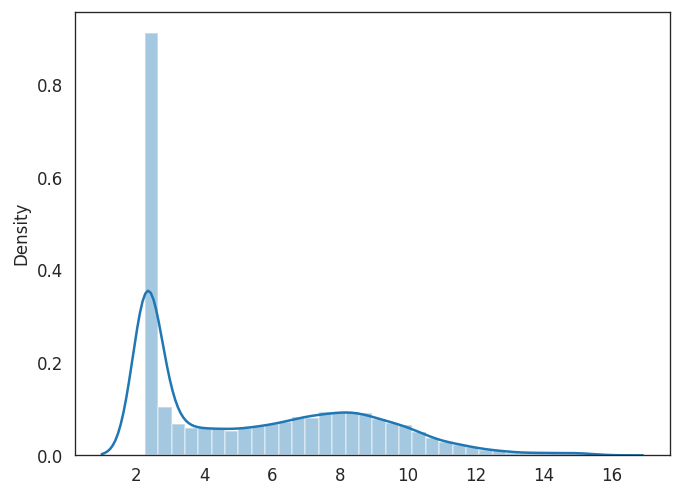

In [25]:
sns.distplot(exp.mean())

If your data plot is similar to the distribution of the normal data on the right then you can continue your analyses whereas if it is similar to the one on left then your data is abnormal and might have RNA degradation. During RNA degradation case please stop the analyses to not have any wrong calculations and choose a new dataset.

# Classification of the example data

The classification section determines each sample subtype relying on the TCGA cohort which was separated into clusters using KNeighborsClusterClassifier storing it all in a MODEL variable where each cluster belongs to a differenct subtype.Then the EXPRESSIONS_MATRIX cohort and signatures.gmt files are passed to ssgsea_formula function to determine each signature(columns) score for every sample (rows).

## Calculating ssGSEA and PROGENy scores of signatures

Calculate ssgsea scores and progeny  
Concatenate them

In [26]:
sign = pd.concat([ssgsea_formula(exp, signatures), run_progeny(exp)], axis=1)
sign.shape

(55, 41)

In [27]:
sign.head()

,Lymphatic_endothelium,Angiogenesis,CAF,Fibroblastic_reticular_cells,Matrix,Matrix_remodeling,Granulocyte_traffic,Protumor_cytokines,Follicular_dendritic_cells,Macrophages,...,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
GSM1358939,-160.876254,896.872755,3919.711386,3689.651433,5876.870836,5117.140715,-2061.804719,3645.144760,3993.136722,1754.957862,...,6079.960648,1095.099634,5896.664394,-2819.694663,1646.742262,5841.041201,121.156252,-351.990797,386.750766,3331.302776
GSM1358940,2185.034275,2575.990926,4826.591712,5182.149349,6670.413278,6930.909019,-301.631037,4075.105078,6624.723233,1939.012559,...,6579.714463,1069.881426,6011.486202,-2802.103041,1821.945534,6000.588490,114.289349,-362.913911,395.411393,3212.268411
GSM1358941,-440.063110,1277.589174,4691.090399,4818.726509,6714.593309,7485.075341,-2614.745564,3601.739387,5935.233492,114.513259,...,5488.651978,1279.928709,5633.632101,-2693.907177,1824.552162,5646.854135,96.903704,-324.242911,374.021116,3314.927354
GSM1358942,631.707180,1861.778047,6457.318986,5706.337687,7626.186603,8535.359424,-1466.839608,3701.799906,3746.375372,2354.974009,...,5765.952875,1236.627929,5777.963537,-2744.846346,2085.213090,5884.520618,66.714042,-435.153794,392.913515,3292.002922
GSM1358943,1217.914505,1565.561173,3574.439413,3625.067635,5339.923651,6208.988263,-1880.800201,3230.314962,6074.992741,313.402573,...,5829.559431,1096.409014,5416.434101,-2784.548138,1694.701682,5533.012806,89.985699,-298.601421,392.335983,3123.659088


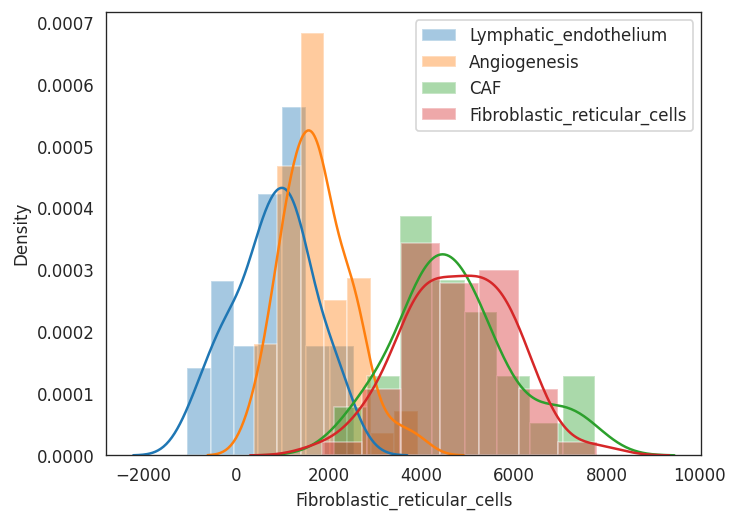

In [28]:
# generating distribution plot for the signatures

_, ax = plt.subplots(1, 1)
for i in sign.columns[:4]:
    sns.distplot(sign[i], label=i, ax=ax, kde=True)
ax.legend()

In [29]:
# scaling signatures to improve accuracy and to faciliate visualisation
sign_sc = median_scale(sign, 3)
sign_sc.shape

(55, 41)

In [30]:
sign_sc.head()

,Lymphatic_endothelium,Angiogenesis,CAF,Fibroblastic_reticular_cells,Matrix,Matrix_remodeling,Granulocyte_traffic,Protumor_cytokines,Follicular_dendritic_cells,Macrophages,...,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
GSM1358939,-1.436759,-1.344182,-0.747056,-1.252811,-0.827535,-1.515633,-0.178132,-0.583759,-1.941545,-0.344663,...,-1.159207,-1.039683,-0.225652,-0.463819,-1.096586,-0.261157,0.284551,0.067274,-1.032242,0.709379
GSM1358940,1.972933,1.578868,0.182446,0.337655,-0.049585,0.202221,1.554106,0.008779,0.264053,-0.183658,...,0.000000,-1.545051,0.083240,-0.191182,0.212244,0.211701,-0.116696,-0.211603,-0.332650,-0.582935
GSM1358941,-1.842546,-0.681422,0.043564,-0.049623,-0.006273,0.727082,-0.722297,-0.643577,-0.313825,-1.779664,...,-2.530780,2.664249,-0.933257,1.485650,0.231716,-0.836680,-1.132575,0.775703,-2.060522,0.531597
GSM1358942,-0.284769,0.335549,1.853851,0.896251,0.887409,1.721826,0.407390,-0.505681,-2.148362,0.180210,...,-1.887565,1.796511,-0.544979,0.696189,2.178944,-0.132295,-2.896619,-2.055953,-0.534425,0.282714
GSM1358943,0.567261,-0.180113,-1.100941,-1.321634,-1.353932,-0.481524,0.000000,-1.155446,-0.196689,-1.605683,...,-1.740026,-1.013444,-1.517560,0.080886,-0.738312,-1.174078,-1.536808,1.430353,-0.581077,-1.544936


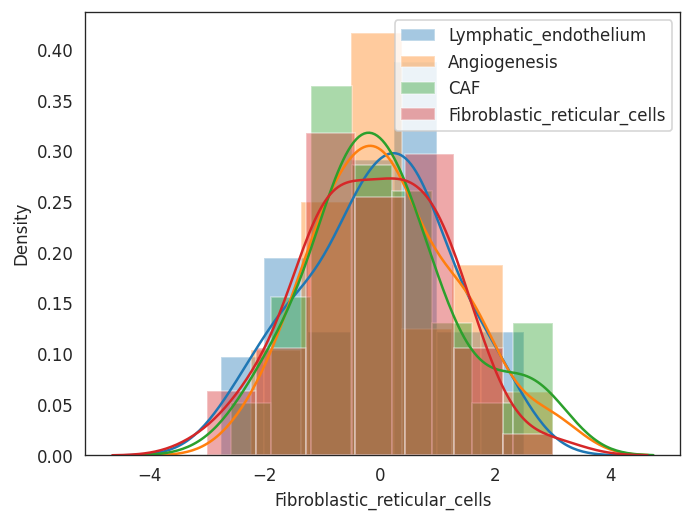

In [31]:
# generating distribution plots for already scaled signature values

_, ax = plt.subplots(1, 1)
for i in sign_sc.columns[:4]:
    sns.distplot(sign_sc[i], label=i, ax=ax, kde=True)
ax.legend()

Below are provided several boxplots to make it easier the understanding of each subtype to the corresponding gene signature scores.

<AxesSubplot:xlabel='BAGS_class', ylabel='Follicular_dendritic_cells'>

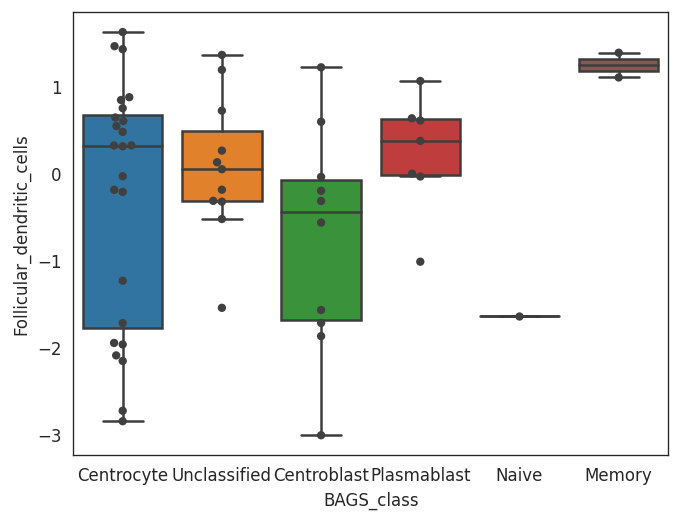

In [32]:
sns.boxplot(y=sign_sc.Follicular_dendritic_cells, x=ann.BAGS_class, fliersize=0)
sns.swarmplot(y=sign_sc.Follicular_dendritic_cells, x=ann.BAGS_class, s=5, color='.25')

<AxesSubplot:xlabel='BAGS_class', ylabel='Proliferation_rate'>

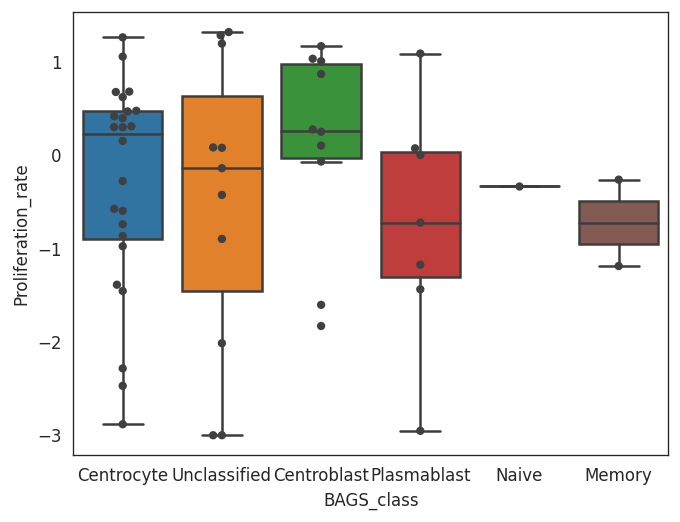

In [33]:
sns.boxplot(y=sign_sc.Proliferation_rate, x=ann.BAGS_class, fliersize=0)
sns.swarmplot(y=sign_sc.Proliferation_rate, x=ann.BAGS_class, s=5, color='.25')

## Classifying the example cohort

This subsection starts classification of the example cohort with the help of the KNN LME_MODEL based on the reference cohort after which it gives a pieplot representation of the LME subtypes percentages on the example cohort.

In [34]:
lme_predicted = LME_MODEL.predict(sign_sc[LME_MODEL.X.columns]).rename('LME')

<AxesSubplot:xlabel='LME'>

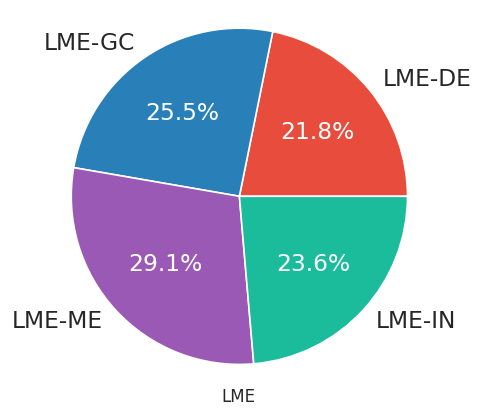

In [35]:
vector_pie_plot(lme_predicted, palette=lme_p)

In [36]:
#Here you can see the COO subtypes of DLBCL for each LME subtype sample
pd.crosstab(ann.COO_BG, lme_predicted)[lme_o]

LME,LME-GC,LME-ME,LME-IN,LME-DE
COO_BG,,,,
ABC,6,4,7,6
GCB,8,12,6,6


In [37]:
so = list(pd.concat([ann.COO_BG[ann.COO_BG==i] for i in ['GCB', 'ABC']]).index)
so = list(pd.concat([lme_predicted.loc[so][lme_predicted.loc[so]==i] for i in lme_o]).index)
len(so)

55

Below is the last codeblock of the whole analysis pipeline where you are provided with the gene signatures heat map with the corresponding LME subtypes which is also divided into 2 subtypes of COO DLBCL.

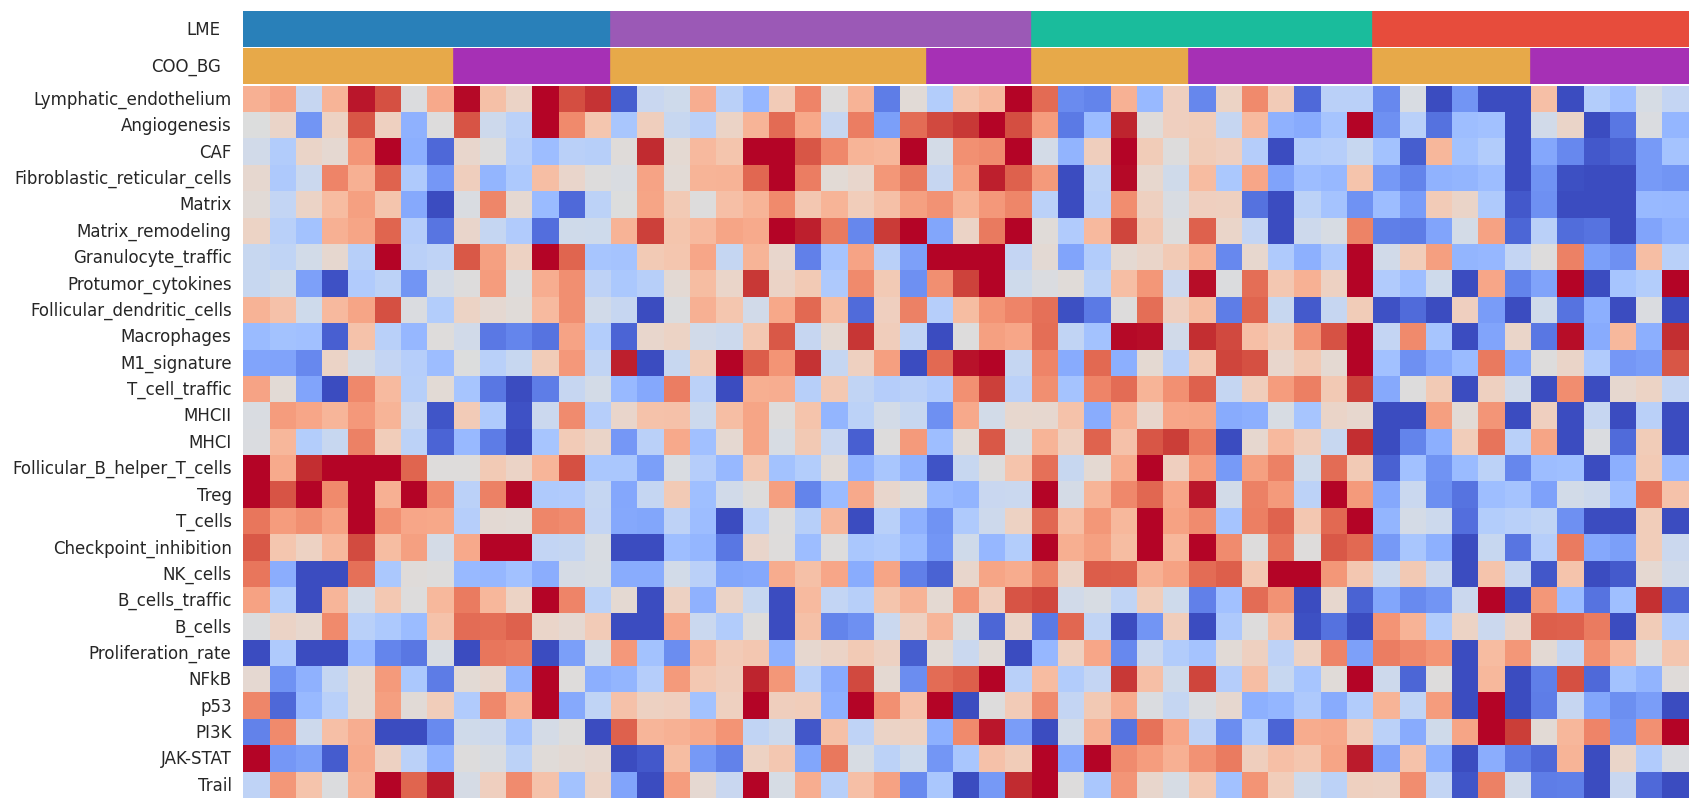

In [38]:
af = axis_matras([.3, .3, 6], x_len=14)

ax = next(af)
line_palette_annotation_plot(lme_predicted[so], ax=ax, palette=lme_p)

ax = next(af)
line_palette_annotation_plot(ann.COO_BG[so], ax=ax, palette=dlbcl_subtype_p)

ax = next(af)
sns.heatmap(sign_sc.loc[so, signatures_selected + progeny_selected + ['JAK-STAT', 'Trail']].clip(-2, 2).T,
            yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm, ax=ax)
plt.tight_layout(pad=.1)